# 迁移学习微调训练图像分类模型

在自己的图像分类数据集上，使用ImageNet预训练图像分类模型初始化，改动分类层，迁移学习微调训练

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 导入工具包

In [2]:
import time
import os
# import copy
import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

## 获取计算硬件

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [5]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入图像分类数据集

In [10]:
# 数据集文件夹路径
dataset_dir = 'melon17_split'

In [11]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 melon17_split/train
测试集路径 melon17_split/val


In [12]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [13]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 2076
类别个数 17
各类别名称 ['丝瓜', '人参果', '佛手瓜', '冬瓜', '南瓜', '哈密瓜', '木瓜', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '白兰瓜', '羊角蜜', '苦瓜', '西瓜', '西葫芦', '黄瓜']


In [14]:
print('训练集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集图像数量 509
类别个数 17
各类别名称 ['丝瓜', '人参果', '佛手瓜', '冬瓜', '南瓜', '哈密瓜', '木瓜', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '白兰瓜', '羊角蜜', '苦瓜', '西瓜', '西葫芦', '黄瓜']


## 类别和索引号 一一对应

In [15]:
# 各类别名称
class_names = train_dataset.classes

In [16]:
class_names

['丝瓜',
 '人参果',
 '佛手瓜',
 '冬瓜',
 '南瓜',
 '哈密瓜',
 '木瓜',
 '甜瓜-伊丽莎白',
 '甜瓜-白',
 '甜瓜-绿',
 '甜瓜-金',
 '白兰瓜',
 '羊角蜜',
 '苦瓜',
 '西瓜',
 '西葫芦',
 '黄瓜']

In [17]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'丝瓜': 0,
 '人参果': 1,
 '佛手瓜': 2,
 '冬瓜': 3,
 '南瓜': 4,
 '哈密瓜': 5,
 '木瓜': 6,
 '甜瓜-伊丽莎白': 7,
 '甜瓜-白': 8,
 '甜瓜-绿': 9,
 '甜瓜-金': 10,
 '白兰瓜': 11,
 '羊角蜜': 12,
 '苦瓜': 13,
 '西瓜': 14,
 '西葫芦': 15,
 '黄瓜': 16}

In [18]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [19]:
idx_to_labels

{0: '丝瓜',
 1: '人参果',
 2: '佛手瓜',
 3: '冬瓜',
 4: '南瓜',
 5: '哈密瓜',
 6: '木瓜',
 7: '甜瓜-伊丽莎白',
 8: '甜瓜-白',
 9: '甜瓜-绿',
 10: '甜瓜-金',
 11: '白兰瓜',
 12: '羊角蜜',
 13: '苦瓜',
 14: '西瓜',
 15: '西葫芦',
 16: '黄瓜'}

In [76]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)

## 定义数据加载器DataLoader

In [20]:
from torch.utils.data import DataLoader

In [21]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## 查看一个batch的图像和标注

In [22]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [23]:
images.shape

torch.Size([32, 3, 224, 224])

In [24]:
labels

tensor([ 2, 13,  0, 13,  7, 15,  6, 12,  1,  6,  4, 14,  2, 11,  0, 13,  5,  1,
         3, 12,  5,  1,  8, 12,  9, 11, 13, 15,  4,  4, 13, 10])

## 可视化一个batch的图像和标注

In [25]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [26]:
images[5].shape

(3, 224, 224)

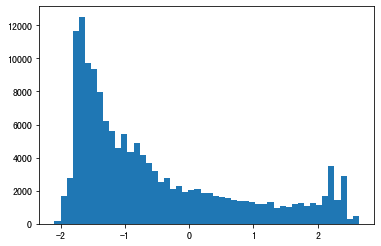

In [27]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:0')

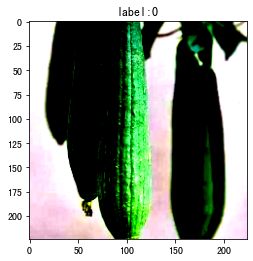

In [28]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [29]:
pred_ID = labels[idx].item()

In [30]:
pred_ID

0

In [33]:
pred_classname = idx_to_labels[pred_ID]

In [34]:
pred_classname

'丝瓜'

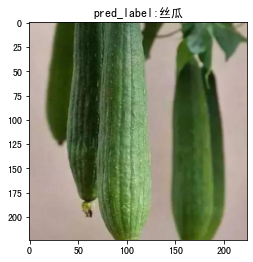

In [35]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('pred_label:'+ pred_classname)
plt.show()

## 导入训练需使用的工具包

In [36]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

## 选择迁移学习训练方式

斯坦福CS231N【迁移学习】中文精讲：https://www.bilibili.com/video/BV1K7411W7So

斯坦福CS231N【迁移学习】官方笔记：https://cs231n.github.io/transfer-learning/

### 选择一：只微调训练模型最后一层（全连接分类层）

In [37]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, len(class_names))

In [38]:
model.fc

Linear(in_features=512, out_features=17, bias=True)

In [39]:
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

### 选择二：微调训练所有层

In [34]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, len(class_names))

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 选择三：随机初始化模型全部权重，从头训练所有层

In [42]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, len(class_names))

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 训练配置

In [40]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 学习率指数下降策略，每 4 个 epoch， 降为原来的 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 训练轮次 Epoch
EPOCHS = 20

## 模拟一个batch的训练

In [41]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [42]:
# 输入模型，执行前向预测
outputs = model(images)

In [43]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 17])

In [44]:
# 由 logit，计算当前 batch的，交叉熵损失函数
loss = criterion(outputs, labels)

In [45]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [46]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [47]:
preds

tensor([ 9, 16,  9,  0,  8,  0,  0,  4,  9, 15, 15,  9, 15, 15,  9, 16,  0, 10,
         9,  9, 15, 16, 15, 16, 10, 16,  0,  0,  9, 15, 10,  0],
       device='cuda:0')

## 运行训练

In [48]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    # 遍历每个 batch
    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


## 在测试集上初步测试

In [49]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 16/16 [00:01<00:00, 10.06it/s]

测试集上的准确率为 78.585 %


## 保存模型

In [50]:
torch.save(model, 'checkpoints/melon17_pytorch_20220812.pth')

## 参考文档

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://www.bilibili.com/video/BV1qe4y1D7zD

https://www.bilibili.com/video/BV14J411X7Bb

https://www.bilibili.com/video/BV1w4411u7ay